## 1. Librerias

In [1]:
import surprise
import numpy as np
import pandas as pd
from surprise.accuracy import rmse
import seaborn as sns
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
import random
import implicit
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from lightfm import LightFM
from lightfm import evaluation
from lightfm.data import Dataset
from implicit.evaluation import precision_at_k, ndcg_at_k
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle


## 2. Análisis exploratorio

### Lectura de archivo train

In [2]:
df_train = pd.read_csv("yelp_train.csv")
df_train.head(5)

,review_id,user_id,item_id,stars,useful,funny,cool,text,date
0,JeyxU-n4mjXW672Hq_8Miw,YuX70bdZdGXUdyU1mKaP4g,W06QBC9vkxA5CVBNVrOMRA,4.0,1,0,1,Drinks were good. I had an apple martini. Bein...,2013-06-02 16:20:07
1,rVQtQr_XuuGoP7KacWYITQ,YuX70bdZdGXUdyU1mKaP4g,9gObo5ltOMo6UgsaXaHPWA,4.0,1,0,0,I was taken here for my birthday by my boyfrie...,2014-01-05 15:32:14
2,hzRcnl-IUj9xvqCCbRLcsg,YuX70bdZdGXUdyU1mKaP4g,J8S7cPPlTgsQnXKVfTyN8g,4.0,0,0,0,"Despite the small size, the food is amazing. S...",2014-02-09 16:37:51
3,lM_VD53pCj_zAhiwbBuEQg,YuX70bdZdGXUdyU1mKaP4g,h7n599RGtvFLmLycugT2MQ,3.0,6,0,0,"I've eaten here twice, I didn't want to write ...",2014-03-08 15:21:26
4,5V3mb55XDrrOUqemJGNZwA,YuX70bdZdGXUdyU1mKaP4g,6KXJk2AWH3NxZBuCdkggVQ,4.0,1,0,0,I found this bakery here on Yelp. After viewin...,2014-03-25 10:02:23


In [3]:
df_train_reviews_changed = df_train
df_train_reviews_changed["stars"] = df_train["stars"].apply(lambda x: 1 if x >= 3 else 0)
df_train_reviews_changed.head(5)

,review_id,user_id,item_id,stars,useful,funny,cool,text,date
0,JeyxU-n4mjXW672Hq_8Miw,YuX70bdZdGXUdyU1mKaP4g,W06QBC9vkxA5CVBNVrOMRA,1,1,0,1,Drinks were good. I had an apple martini. Bein...,2013-06-02 16:20:07
1,rVQtQr_XuuGoP7KacWYITQ,YuX70bdZdGXUdyU1mKaP4g,9gObo5ltOMo6UgsaXaHPWA,1,1,0,0,I was taken here for my birthday by my boyfrie...,2014-01-05 15:32:14
2,hzRcnl-IUj9xvqCCbRLcsg,YuX70bdZdGXUdyU1mKaP4g,J8S7cPPlTgsQnXKVfTyN8g,1,0,0,0,"Despite the small size, the food is amazing. S...",2014-02-09 16:37:51
3,lM_VD53pCj_zAhiwbBuEQg,YuX70bdZdGXUdyU1mKaP4g,h7n599RGtvFLmLycugT2MQ,1,6,0,0,"I've eaten here twice, I didn't want to write ...",2014-03-08 15:21:26
4,5V3mb55XDrrOUqemJGNZwA,YuX70bdZdGXUdyU1mKaP4g,6KXJk2AWH3NxZBuCdkggVQ,1,1,0,0,I found this bakery here on Yelp. After viewin...,2014-03-25 10:02:23


### Lectura de archivo test

In [4]:
df_test = pd.read_csv("yelp_test_user_ids.csv")
df_test.head(5)

,user_id
0,YuX70bdZdGXUdyU1mKaP4g
1,vGXqgn5tohJnrnmYRNiRbw
2,0YI0fA3naGahJHRH6RnDzw
3,7rULEZMof7FRaJTFk1Wkgw
4,kLWW45rw2qSospTQ8L1dzg


### Lectura de archivo val

In [5]:
df_val = pd.read_csv("yelp_val.csv")
df_val.head(5)

,review_id,user_id,item_id,stars,useful,funny,cool,text,date
0,WUagv7KF-ASyWDwmn0mxAg,YuX70bdZdGXUdyU1mKaP4g,U4ALy9epZHEwFl3FnGun6w,3.0,3,1,1,"I really wanted to give 4 stars, maybe next ti...",2017-04-01 15:29:05
1,ExSWtAoO0uKvA3HuPqenUA,vGXqgn5tohJnrnmYRNiRbw,ZKPrXH_GNW_AtZ31tP3NmA,4.0,1,0,0,"I went here for lunch, had excellent food, and...",2011-07-12 21:36:41
2,iXaiVvdwKWGg2fJ85SCPqw,0YI0fA3naGahJHRH6RnDzw,d32ypk0TUSxzYxKnMMuFNg,4.0,0,0,0,I love this place. They have great food. Their...,2018-06-25 16:49:09
3,z4l6d_eFb9e--WrTyuzcLA,7rULEZMof7FRaJTFk1Wkgw,FKgkGKRJYppEGCYuK_DOGg,4.0,0,0,0,"This is a fun little gem, especially during Ha...",2014-07-18 03:39:21
4,zII7rTs-k6U0vrRrv6qX8Q,kLWW45rw2qSospTQ8L1dzg,8jXmNMrGJ2acUG1R-D5e6w,3.0,0,1,0,"i moved to nola from chicago, so it's very har...",2013-10-01 15:23:19


In [6]:
df_val_reviews_changed = df_val
df_val_reviews_changed["stars"] = df_val["stars"].apply(lambda x: 1 if x >= 3 else 0)

### Items únicos según users e items

In [7]:
print("Users:", df_train["user_id"].nunique())
print("Items:", df_train["item_id"].nunique())

Users: 9028
Items: 9348


In [8]:
print("Users:", df_val["user_id"].nunique())
print("Items:", df_val["item_id"].nunique())

Users: 9028
Items: 5294


In [9]:
users_set_train = set(df_train["user_id"].unique())
users_set_val = set(df_val["user_id"].unique())
mismo_user = users_set_val == users_set_train
print(mismo_user)

True


Se puede ver que son los mismos usuarios en ambos dataset

In [10]:
items_set_train = set(df_train["item_id"].unique())
items_set_val = set(df_val["item_id"].unique())
item_val = items_set_train.issubset(items_set_val)
print(item_val)


False


In [11]:
items = df_train.groupby(["item_id"]).count()["user_id"]
items.describe()

count    9348.000000
mean        7.453359
std         7.109505
min         1.000000
25%         3.000000
50%         5.000000
75%         9.000000
max        97.000000
Name: user_id, dtype: float64

In [12]:
most_active_items = items.sort_values(ascending=False)

most_active_items = most_active_items.to_frame().reset_index().rename(columns={"user_id": "interactions"})

most_active_items.head(10)

,item_id,interactions
0,ytynqOUb3hjKeJfRj5Tshw,97
1,9PZxjhTIU7OgPIzuGi89Ew,95
2,ctHjyadbDQAtUFfkcAFEHw,80
3,j-qtdD55OLfSqfsWuQTDJg,80
4,6ajnOk0GcY9xbb5Ocaw8Gw,78
5,qQO7ErS_RAN4Vs1uX0L55Q,73
6,ntiIq1FNqduOyyowMFGh5A,72
7,QHWYlmVbLC3K6eglWoHVvA,67
8,OdIBX09glfXNVSyd0RnIeg,67
9,c_4c5rJECZSfNgFj7frwHQ,67


In [13]:
items_val = df_val.groupby(["item_id"]).count()["user_id"]
most_active_items_val = items_val.sort_values(ascending=False)

most_active_items_val = most_active_items_val.to_frame().reset_index().rename(columns={"user_id": "interactions"})

In [14]:
most_active_items["interactions"].sum()

69674

In [15]:
most_active_items_val["interactions"].sum()

9028

In [16]:
users = df_train.groupby(["user_id"]).count()["item_id"]
users.describe()

count    9028.000000
mean        7.717545
std         7.766332
min         1.000000
25%         3.000000
50%         6.000000
75%         9.000000
max       127.000000
Name: item_id, dtype: float64

### Cambiar los ids largos a numeros

In [17]:
most_active_users = users.sort_values(ascending=False)

most_active_users = most_active_users.to_frame().reset_index().rename(columns={"item_id": "interactions"})

most_active_users.head(10)

,user_id,interactions
0,_BcWyKQL16ndpBdggh2kNA,127
1,ET8n-r7glWYqZhuR6GcdNw,118
2,vHc-UrI9yfL_pnnc6nJtyQ,101
3,bJ5FtCtZX3ZZacz2_2PJjA,101
4,pou3BbKsIozfH50rxmnMew,95
5,1HM81n6n4iPIFU5d2Lokhw,90
6,ouODopBKF3AqfCkuQEnrDg,89
7,CfX4sTIFFNaRchNswqhVfg,87
8,fr1Hz2acAb3OaL3l6DyKNg,83
9,bYENop4BuQepBjM1-BI3fA,82


In [18]:
most_active_users["interactions"].sum()


69674

### Gráfico número interaccion por usuario

Se debe graficar el número de interacciones por usuarios. Conseguir los 5 ids más importantes, comentar la distribución obtenida y porcentaje hecha por los ids con respecto al total.

/home/jose/Escritorio/2023-2/Sistemas Recomendadores/Tareas/T1/IA/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jose/Escritorio/2023-2/Sistemas Recomendadores/Tareas/T1/IA/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jose/Escritorio/2023-2/Sistemas Recomendadores/Tareas/T1/IA/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


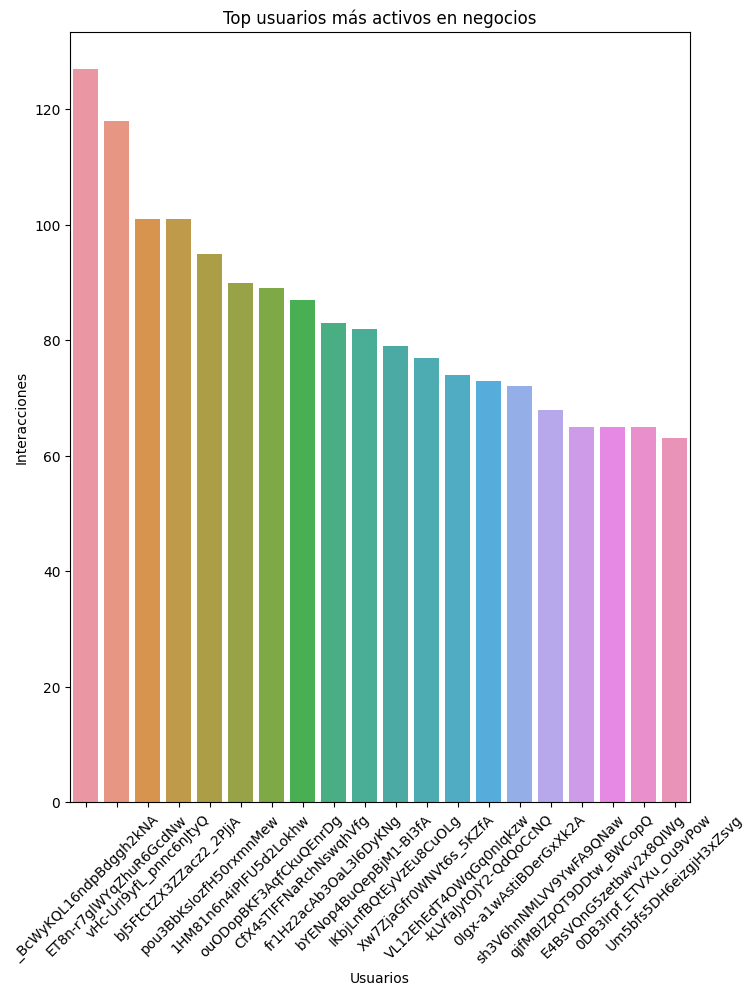

In [19]:
plt.figure(figsize=(8 , 10))

sns.barplot(x = "user_id", y = "interactions", data= most_active_users[:20], orient = 'v')
plt.xlabel("Usuarios")
plt.ylabel("Interacciones")
plt.title("Top usuarios más activos en negocios")
plt.xticks(rotation = 45)
plt.show()


Este gráfico se utiliza para ver mejor la distribución. Pareciera una exponencial del tipo a ** x, donde a se encuentra entre en el siguiente intervalo 0 < a < 1

En el Eje X, se muestran los usuarios y en el eje Y se muestra la cantidad de Interacciones de cada usuario.

/home/jose/Escritorio/2023-2/Sistemas Recomendadores/Tareas/T1/IA/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jose/Escritorio/2023-2/Sistemas Recomendadores/Tareas/T1/IA/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jose/Escritorio/2023-2/Sistemas Recomendadores/Tareas/T1/IA/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


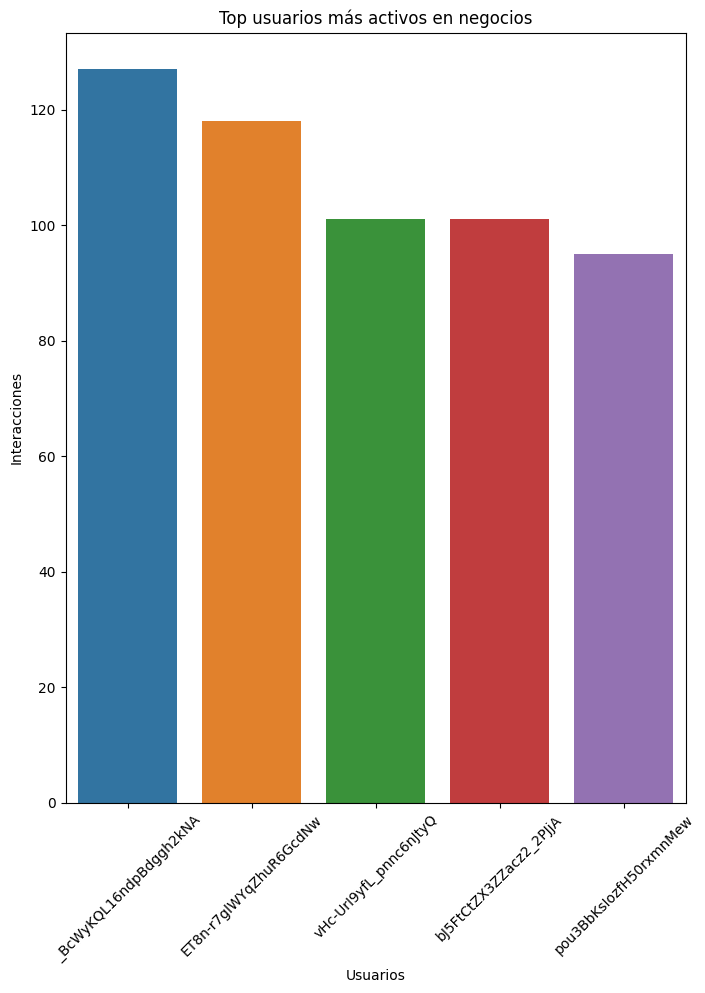

In [20]:
plt.figure(figsize=(8 , 10))

sns.barplot(x = "user_id", y = "interactions", data= most_active_users[:5], orient = 'v')
plt.xlabel("Usuarios")
plt.ylabel("Interacciones")
plt.title("Top usuarios más activos en negocios")
plt.xticks(rotation = 45)
plt.show()

Notar que el primer usuario interactuó con sobre 120 negocios y el quinto un poco menos de 100 negocios. Ahora veremos cuál es el porcentaje de interacciones de estos 5 usuarios con respecto al total

In [21]:
interactions_by_active_users = (most_active_users[:5]['interactions'].sum() / users.sum()) * 100
print(f"Porcentaje de interacciones de los 5 usuarios más activos: {interactions_by_active_users}")

Porcentaje de interacciones de los 5 usuarios más activos: 0.7779085455119557


Es de solo 0.78 por ciento aproxidamente. Pensando en que tenemos 9028 usuarios y por el primer gráfico, los usuarios suelen interactuar bastante con los negocios, es normal encontrar un porcentaje pequeño.

### Gráfico interacción por negocio

/home/jose/Escritorio/2023-2/Sistemas Recomendadores/Tareas/T1/IA/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jose/Escritorio/2023-2/Sistemas Recomendadores/Tareas/T1/IA/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jose/Escritorio/2023-2/Sistemas Recomendadores/Tareas/T1/IA/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


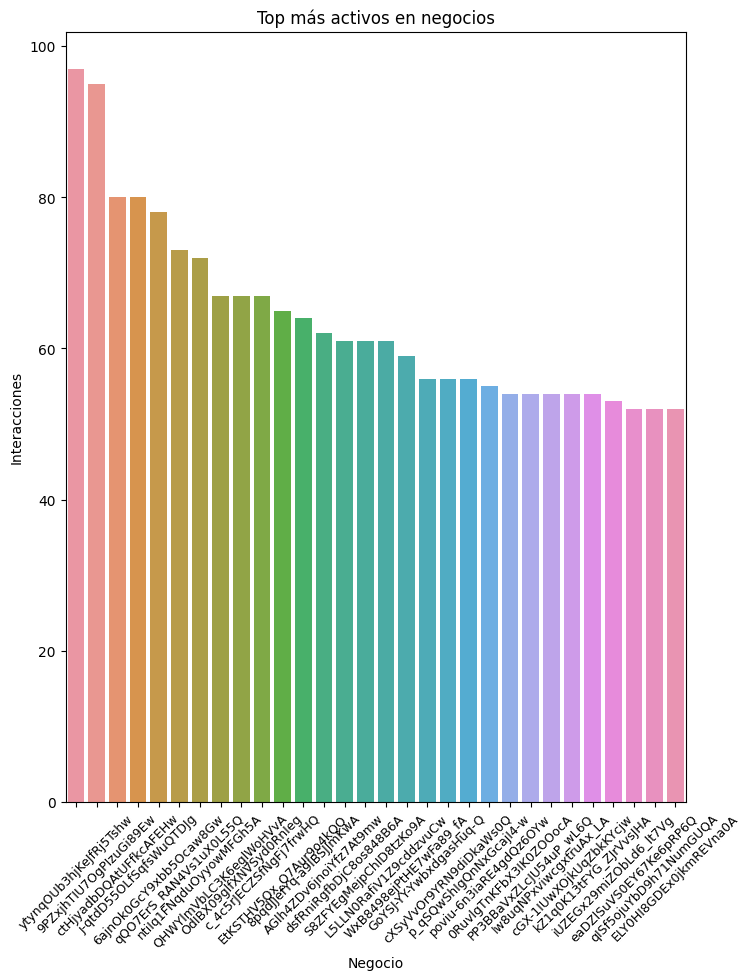

In [22]:
plt.figure(figsize=(8 , 10))

sns.barplot(x = "item_id", y = "interactions", data= most_active_items[:30], orient = 'v')
plt.xlabel("Negocio")
plt.ylabel("Interacciones")
plt.title("Top más activos en negocios")
plt.xticks(rotation = 45, fontsize = 9)
plt.show()

/home/jose/Escritorio/2023-2/Sistemas Recomendadores/Tareas/T1/IA/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jose/Escritorio/2023-2/Sistemas Recomendadores/Tareas/T1/IA/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jose/Escritorio/2023-2/Sistemas Recomendadores/Tareas/T1/IA/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


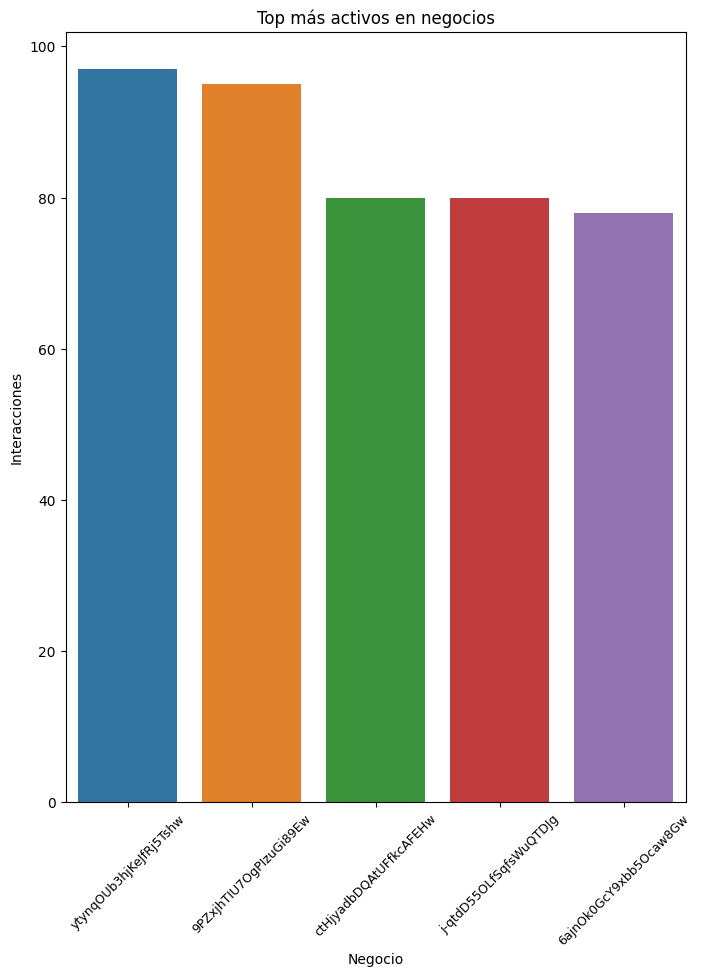

In [23]:
plt.figure(figsize=(8 , 10))

sns.barplot(x = "item_id", y = "interactions", data= most_active_items[:5], orient = 'v')
plt.xlabel("Negocio")
plt.ylabel("Interacciones")
plt.title("Top más activos en negocios")
plt.xticks(rotation = 45, fontsize = 9)
plt.show()

Aqui se puede ver en el eje X, los ids de los negocios en el gráfico de barras y en el eje Y, se muestra la cantidad de interacciones de estos negocios.

### Tabla con distintos datos

In [24]:
usuario_distintos = df_train["user_id"].nunique()
item_distintos = df_train["item_id"].nunique()
promedio_item_por_usuario = most_active_items["interactions"].mean()
std_item_por_usuario = most_active_items["interactions"].std()
promedio_usuario_por_item = most_active_users["interactions"].mean()
std_usuario_por_item = most_active_users["interactions"].std()
densidad = items.count() /(users.count() * items.count())
tabla_1 = pd.DataFrame({
    "Metrica": ["Usuarios distintos", "Items distintos", "Promedio de 'item por usuario'", "Desviación de 'item por usuario'", "Promedio de 'usuarios por item'", "Desviación de 'usuarios por item'", "Densidad"],
    "Valor": [(usuario_distintos), (item_distintos), promedio_item_por_usuario, std_item_por_usuario, promedio_usuario_por_item, std_usuario_por_item, densidad]
})
print(tabla_1)

                             Metrica        Valor
0                 Usuarios distintos  9028.000000
1                    Items distintos  9348.000000
2     Promedio de 'item por usuario'     7.453359
3   Desviación de 'item por usuario'     7.109505
4    Promedio de 'usuarios por item'     7.717545
5  Desviación de 'usuarios por item'     7.766332
6                           Densidad     0.000111


## 3. Recomendación no personalizada

### Fórmula para métricas de evaluación

In [25]:
def calculo_metrica(item_relevantes, item_recomendados, k):
    precision_at_k = len(set(item_relevantes).intersection(set(item_recomendados)))/k
    dcg = 0
    idcg = 0
    for i in range(k):
        item = item_recomendados[i]
        if item in item_relevantes:
            num_relevante = 1
        else:
            num_relevante = 0
        dcg += ((2**num_relevante) - 1) / np.log2(i + 2)
    idcg += sum(1 / np.log2(i + 2) for i in range(k))
    ndcg = dcg/idcg
    return precision_at_k, ndcg

lista_items_relevantes = []
for item_id, relevante in zip(df_val_reviews_changed["item_id"], df_val_reviews_changed["stars"]):
    if relevante == 1:
        lista_items_relevantes.append(item_id)
lista_items_relevantes = set(lista_items_relevantes)
lista_items_relevantes = list(lista_items_relevantes)

con ayuda de chatgpt para crear la fórmula de internet sobre ndcg

### Recomendación de los 30 negocios más populares

In [26]:
negocios_populares = most_active_items[:30]
print(negocios_populares)

                   item_id  interactions
0   ytynqOUb3hjKeJfRj5Tshw            97
1   9PZxjhTIU7OgPIzuGi89Ew            95
2   ctHjyadbDQAtUFfkcAFEHw            80
3   j-qtdD55OLfSqfsWuQTDJg            80
4   6ajnOk0GcY9xbb5Ocaw8Gw            78
5   qQO7ErS_RAN4Vs1uX0L55Q            73
6   ntiIq1FNqduOyyowMFGh5A            72
7   QHWYlmVbLC3K6eglWoHVvA            67
8   OdIBX09glfXNVSyd0RnIeg            67
9   c_4c5rJECZSfNgFj7frwHQ            67
10  EtKSTHV5Qx_Q7Aur9o4kQQ            65
11  8pqdJjefYq-a9IBSJJmKwA            64
12  AGlh4ZDv6jnoiYfz7At9mw            62
13  dsfRniRgfbDjC8os848B6A            61
14  S8ZFYEgMejpChID8tzKo9A            61
15  L5LLN0RafiV1Z9cddzvuCw            61
16  WxB8498ejPtHE7wFa89_fA            59
17  GoYSJ-YY-YwbxdgasHuq-Q            56
18  cXSyVvOr9YRN9diDkaWs0Q            56
19  p_qSQwShIgQnNxGcajI4-w            56
20  poviu-6n3iaRE4gdQz6OYw            55
21  0RuvlgTnKFbX3IK0ZOOocA            54
22  PP3BBaVxZLcJU54uP_wL6Q            54
23  Iw8uqNPxviwc

In [27]:
negocios_populares_10 = (most_active_items[:10])
negocios_populares_10 = negocios_populares_10["item_id"]
negocios_populares_20 = (most_active_items[:20])
negocios_populares_20 = negocios_populares_20["item_id"]
negocios_populares_30 = (most_active_items[:30])
negocios_populares_30 = negocios_populares_30["item_id"]
contador = 0
for k in [10, 20, 30]:
    precision_por_usuario = []
    ndcg_por_usuario = []
    for _, row in df_val_reviews_changed.iterrows():
        item_relevante = row["item_id"]
        precision, ndcg = calculo_metrica(item_relevante, negocios_populares_30, k)
        precision_por_usuario.append(precision)
        contador += 1
        ndcg_por_usuario.append(ndcg)
    promedio_precision = np.mean(precision_por_usuario)
    promedio_ndcg = np.mean(ndcg_por_usuario)
    print(f"precision {k}: {promedio_precision} y ndcg {k}: {promedio_ndcg}")


precision 10: 0.0 y ndcg 10: 0.0006530693734087863
precision 20: 0.0 y ndcg 20: 0.0006255904829889608
precision 30: 0.0 y ndcg 30: 0.0005989078633279252


Si solo recomendaramos los 30 negocios con mayor cantidad de interacciones (los más populares), serían los que se puede ver en la tabla anterior y se puede observar las métricas de evaluación justo debajo de la tabla.

### Recomendación de manera aleatoria

In [28]:
indices_random = random.sample(range(len(most_active_items)), 30)
negocios_aleatorios = most_active_items.iloc[indices_random]
print(negocios_aleatorios[:30])


                     item_id  interactions
2769  XXXpyqzP0B2i8J2eWr2Zig             8
1194  zewTzLyiEQA8LxzNkpAa3Q            13
2346  3zI7Ka2_ZsKh4UwbSFnXdw             9
1270  8MzF1Tlgz0pOkxmhP5dYzA            13
235   fF0aVsxyI51ZfCZoN-F5GQ            26
8278  B91yBSPvAz5O_t9JFafN1Q             2
9162  wgEST8dD-vPpn-6MCptd2w             1
6538  l_slvEnh4v3W8BXF1gYlcQ             3
1140  sAduA1AvV7Z27IGtsx_H3g            14
4440  BK3KoKtev1h8e_GfmcD-iw             6
1042  un0xxX785wfQfprryh0TjQ            14
1110  pc8D9b_rnL_I8ak91tKjsg            14
3527  Qk5HvQpVC17MaLlVIiThhw             7
7032  eFwFIh7olBwMHQ6ByoRH-Q             3
2385  r4eDzodjjoxk79ydS7V67Q             9
7190  hgyKTNWEP8eeTdUm61bUrw             3
7297  M0Cb0ufPxOSHSrZAKMmUmg             3
3962  Df7iAocnliScK-fbfzKI4g             6
7347  c5CA8uSN0oZsxtz8t92uSA             3
8888  WNqqyUtEmrqCBEHNV9sj5Q             1
4702  bBKR4pH312WAum3IZ32d4Q             5
6956  6ZtfPUPOfYdFXg-2ndhYjg             3
7766  Mfyqn

In [29]:
for k in [10, 20, 30]:
    precision_por_usuario = []
    ndcg_por_usuario = []
    for _, row in df_val_reviews_changed.iterrows():
        item_relevante = row["item_id"]
        precision, ndcg = calculo_metrica(item_relevante, negocios_aleatorios["item_id"][:k].to_list(), k)
        precision_por_usuario.append(precision)
        contador += 1
        ndcg_por_usuario.append(ndcg)
    promedio_precision = np.mean(precision_por_usuario)
    promedio_ndcg = float(np.mean(ndcg_por_usuario))
    "{:.10f}".format(promedio_precision)
    "{:.10f}".format(promedio_ndcg)
    print(f"precision {k}: {promedio_precision} y ndcg {k}: {float(promedio_ndcg)}")

precision 10: 0.0 y ndcg 10: 0.00016294185162178343
precision 20: 0.0 y ndcg 20: 0.0001410365698798487
precision 30: 0.0 y ndcg 30: 0.00011839397242816585


## 4. Recomendación basada en feedback implícito

Se cambian los ids a enteros para poder ejecutar los métodos

In [30]:
data = pd.concat([df_train_reviews_changed["user_id"], df_train_reviews_changed["item_id"], df_train_reviews_changed["stars"]], axis= 1)

In [31]:
negocio_id_int = {}
user_id_int = {}
numero_id_user = 0
numero_id_negocio = 0

In [32]:
data["user_id"] = data["user_id"].astype(str)
for user_id in data["user_id"].unique():
    user_id_int[user_id] = numero_id_user
    numero_id_user += 1
data["item_id"] = data["item_id"].astype(str)
for negocio_id in data["item_id"].unique():
    negocio_id_int[negocio_id] = numero_id_negocio
    numero_id_negocio += 1
data["user_id"] = data["user_id"].map(user_id_int)

data["item_id"] = data["item_id"].map(negocio_id_int)
data.head()

,user_id,item_id,stars
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1


In [33]:
matriz_usuario_negocio = csr_matrix((data["stars"], (data["user_id"], data["item_id"])))


Ahora que tenemos la matriz, podemos utilizar ALS.

### ALS

Habra que transformar el dataset de val a matriz

In [34]:
data_val = pd.concat([df_val_reviews_changed["user_id"], df_val_reviews_changed["item_id"], df_val_reviews_changed["stars"]], axis= 1)
data_val.head(5)
contador_user = 0


In [35]:
data_val["user_id"] = data_val["user_id"].astype(str)
data_val["item_id"] = data_val["item_id"].astype(str)

data_val["user_id"] = data_val["user_id"].map(user_id_int)
data_val["item_id"] = data_val["item_id"].map(negocio_id_int)

print(contador_user)
data_val.head(5)

0


,user_id,item_id,stars
0,0,2481.0,1
1,1,702.0,1
2,2,6298.0,1
3,3,4136.0,1
4,4,3256.0,1


In [36]:
data_val["item_id"].fillna(-1, inplace=True)
contador = 0
for item in data_val["item_id"]:
    if item == -1:
        contador+= 1
print(f"Se eliminan {contador} items que no estaban en el data_train")

Se eliminan 180 items que no estaban en el data_train


In [37]:
data_val = data_val[data_val["item_id"] != -1]
data_val["user_id"] = data_val["user_id"].astype(int)
data_val["item_id"] = data_val["item_id"].astype(int)

In [38]:
matriz_usuario_negocio_val = csr_matrix((data_val["stars"], (data_val["user_id"], data_val["item_id"])))

In [39]:
factores_latentes = [10, 20, 30, 50, 100, 200, 500, 1000]
resultados_precision = []
resultados_ndcg = []
resultados_tiempo_ejecucion = []

for factor_latente in factores_latentes:
    tiempo_inicial = time.time()
        
    model_als = implicit.als.AlternatingLeastSquares(factors = factor_latente, regularization = 0.1, iterations = 15, use_gpu=False)
    model_als.fit(matriz_usuario_negocio)

    tiempo = time.time() - tiempo_inicial

    precision = precision_at_k(model_als, matriz_usuario_negocio, matriz_usuario_negocio_val, K = factor_latente)
    precision_mean = np.mean(precision)

    ndgc = ndcg_at_k(model_als, matriz_usuario_negocio, matriz_usuario_negocio_val, K = factor_latente)
    ndgc_mean = np.mean(ndgc)

    resultados_precision.append(precision_mean)
    resultados_ndcg.append(ndgc_mean)
    resultados_tiempo_ejecucion.append(tiempo)



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/8848 [00:00<?, ?it/s]

  0%|          | 0/8848 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/8848 [00:00<?, ?it/s]

  0%|          | 0/8848 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/8848 [00:00<?, ?it/s]

  0%|          | 0/8848 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/8848 [00:00<?, ?it/s]

  0%|          | 0/8848 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/8848 [00:00<?, ?it/s]

  0%|          | 0/8848 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/8848 [00:00<?, ?it/s]

  0%|          | 0/8848 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/8848 [00:00<?, ?it/s]

  0%|          | 0/8848 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/8848 [00:00<?, ?it/s]

  0%|          | 0/8848 [00:00<?, ?it/s]

### Resultado ALS

In [40]:
for factor_latente, precision, ndgc, tiempo in zip(factores_latentes, resultados_precision, resultados_ndcg, resultados_tiempo_ejecucion):
    print(f"Con un factor latente de {factor_latente}, utilizando modelo ALS en un tiempo de ejecución de {tiempo} segundos, se obtuvo precisión de {precision} y ndgc de {ndgc} ")

Con un factor latente de 10, utilizando modelo ALS en un tiempo de ejecución de 3.708587884902954 segundos, se obtuvo precisión de 0.02328209764918626 y ndgc de 0.011202956874040373 
Con un factor latente de 20, utilizando modelo ALS en un tiempo de ejecución de 3.6535463333129883 segundos, se obtuvo precisión de 0.03774864376130199 y ndgc de 0.013766434472590626 
Con un factor latente de 30, utilizando modelo ALS en un tiempo de ejecución de 6.126761198043823 segundos, se obtuvo precisión de 0.05323236889692586 y ndgc de 0.017053811916065875 
Con un factor latente de 50, utilizando modelo ALS en un tiempo de ejecución de 6.695821046829224 segundos, se obtuvo precisión de 0.08216546112115733 y ndgc de 0.022968180538020737 
Con un factor latente de 100, utilizando modelo ALS en un tiempo de ejecución de 8.52666687965393 segundos, se obtuvo precisión de 0.12839059674502712 y ndgc de 0.030568528784174365 
Con un factor latente de 200, utilizando modelo ALS en un tiempo de ejecución de 7.7

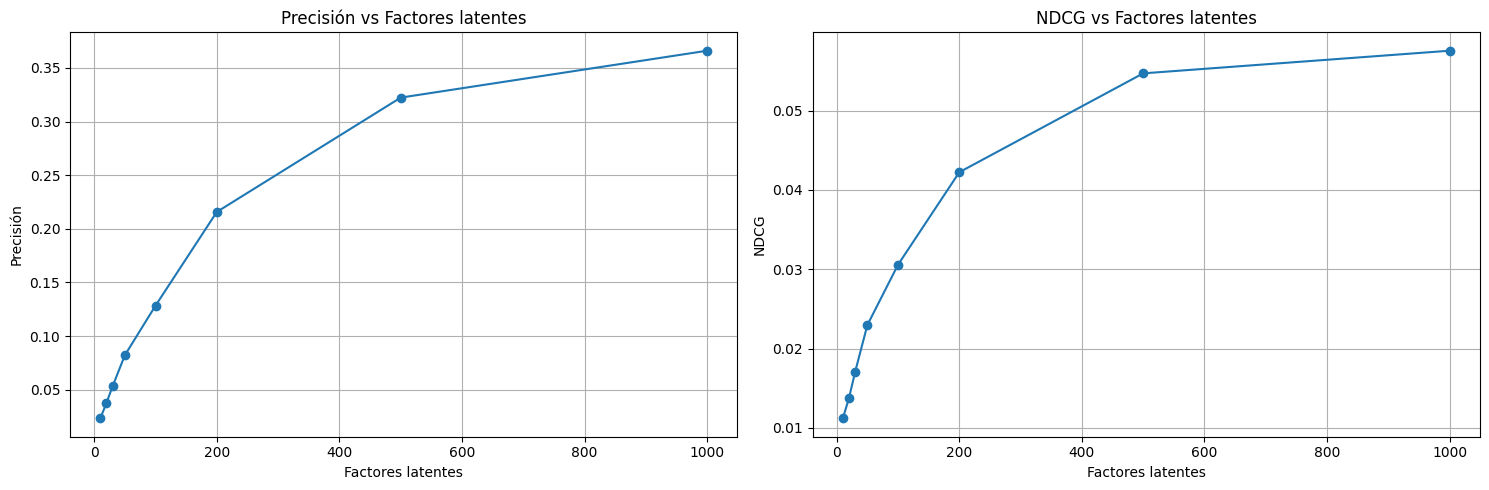

In [41]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(factores_latentes, resultados_precision, marker='o')
plt.title("Precisión vs Factores latentes")
plt.xlabel("Factores latentes")
plt.ylabel("Precisión")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(factores_latentes, resultados_ndcg, marker='o')
plt.title("NDCG vs Factores latentes")
plt.xlabel("Factores latentes")
plt.ylabel("NDCG")
plt.grid(True)

plt.tight_layout()
plt.show()

Se puede ver que alcanza su mejor precisión y ndgc cuando tiene factor latente igual a 1000.

### BPR

Crear interacciones

In [42]:
data_id = Dataset()
data_id.fit(data["user_id"], data["item_id"])
(interacciones, pesos) = data_id.build_interactions([(user_id, item_id, rating) for user_id, item_id, rating in zip(data["user_id"], data["item_id"], data["stars"])])
print(interacciones.shape)

(9028, 9348)


In [43]:
data_id_val = Dataset()
data_id_val.fit(data_val["user_id"], data_val["item_id"])
(interacciones_val, pesos_val) = data_id_val.build_interactions([(user_id, item_id, rating) for user_id, item_id, rating in zip(data_val["user_id"], data_val["item_id"], data_val["stars"])])
print(interacciones_val.shape)

(8848, 5164)


In [44]:

for factor_latente in factores_latentes:
    tiempo_inicial = time.time()
    model_bpr = LightFM(loss = "bpr", no_components= factor_latente)
    model_bpr.fit(interacciones, epochs = 10)
    tiempo = time.time() - tiempo_inicial
    #map_accuracy = evaluation.auc_score(model_bpr, interacciones_val).mean()


FALTA EVALUAR LA PRECISION DE BPR

In [45]:
predicciones = model_bpr.predict(user_ids = data_val["user_id"].to_list(), item_ids= data_val["item_id"].to_list())

In [46]:
indices_orden = np.argsort(-predicciones)
indices_orden = indices_orden[:30]


In [52]:
print(type(indices_orden))
print(indices_orden[:][:10])

<class 'numpy.ndarray'>
[4930 8624 7412 8490 8319 8720 7394 3060 7833 8812]


In [47]:
for k in [10, 20, 30]:
    elementos_recomendados = indices_orden[:, :k]
    #CALCULAR
    #MAP
    #NDGC

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
#for factor_latente, precision, ndgc, tiempo in zip(factores_latentes, resultados_precision_bpr, resultados_ndcg_bpr, tiempos_bpr):
 #   print(f"Con un factor latente de {factor_latente}, utilizando modelo ALS en un tiempo de ejecución de {tiempo}, se obtuvo precisión de {precision} y ndgc de {ndgc} ")

## 5. Recomendación basada en contenido

Lectura vectores

In [ ]:
archivo_tf = "business_tfidf_dict.pkl"
with open(archivo_tf, "rb") as archivo:
    vector_items = pickle.load(archivo)
print(vector_items)

{'MUTTqe8uqyMdBl186RmNeA': array([0., 0., 0., ..., 0., 0., 0.]), 'ROeacJQwBeh05Rqg7F6TCg': array([0., 0., 0., ..., 0., 0., 0.]), '9OG5YkX1g2GReZM0AskizA': array([0., 0., 0., ..., 0., 0., 0.]), 'tMkwHmWFUEXrC9ZduonpTg': array([0., 0., 0., ..., 0., 0., 0.]), 'lk9IwjZXqUMqqOhM774DtQ': array([0., 0., 0., ..., 0., 0., 0.]), 'seKihQKpGGnCeLuELRQPSQ': array([0., 0., 0., ..., 0., 0., 0.]), 'IDtLPgUrqorrpqSLdfMhZQ': array([0., 0., 0., ..., 0., 0., 0.]), 'YNjyv0gfOr2g8lbmUpTnKg': array([0., 0., 0., ..., 0., 0., 0.]), 'oaboaRBUgGjbo2kfUIKDLQ': array([0., 0., 0., ..., 0., 0., 0.]), 'TLZ3-eDPLhUzfsWO4ad6Ug': array([0., 0., 0., ..., 0., 0., 0.]), 'sB45WFgysT617bKWP_WJwA': array([0., 0., 0., ..., 0., 0., 0.]), '3BJxm-HnvzdwD1zjmSbmyQ': array([0., 0., 0., ..., 0., 0., 0.]), 'SZU9c8V2GuREDN5KgyHFJw': array([0., 0., 0., ..., 0., 0., 0.]), 'X_E7U2lVNEwbH_gpOBmAHQ': array([0., 0., 0., ..., 0., 0., 0.]), 'ORL4JE6tz3rJxVqkdKfegA': array([0., 0., 0., ..., 0., 0., 0.]), 'IYlUaKC9nICjiWdk-ShPlg': array([0., 0.

In [ ]:
tfidf_vector = TfidfVectorizer()
matrix_tfidf_user = tfidf_vector.fit_transform(df_train_reviews_changed["text"])
print(matrix_tfidf_user)

  (0, 49306)	0.17541457816518935
  (0, 64723)	0.07979430600439703
  (0, 9514)	0.045981460879983685
  (0, 8667)	0.2732652631135745
  (0, 34543)	0.08481225812437188
  (0, 6030)	0.12111563152624913
  (0, 14652)	0.09412081008617224
  (0, 45036)	0.1390049769157198
  (0, 51969)	0.11885141470001012
  (0, 52137)	0.1878555674544026
  (0, 20706)	0.12493598510199519
  (0, 23376)	0.04246922627205887
  (0, 5214)	0.07204298086465119
  (0, 25566)	0.07372763329386978
  (0, 65244)	0.07678201816069549
  (0, 54736)	0.10422629608887783
  (0, 16598)	0.08899894381589499
  (0, 59169)	0.0495221678792576
  (0, 53315)	0.100307587318575
  (0, 36666)	0.17326364542081943
  (0, 63891)	0.21171384905210391
  (0, 25862)	0.08411744721332866
  (0, 3445)	0.034003719268727965
  (0, 11611)	0.0946862303129712
  (0, 2076)	0.1461909377582684
  :	:
  (69673, 32849)	0.10743838749073967
  (69673, 35064)	0.1268264182080234
  (69673, 59019)	0.23212123991619904
  (69673, 34281)	0.07118387100551561
  (69673, 30633)	0.118836959458520

# VER QUE HACER AQUI

In [ ]:
for id in df_train_reviews_changed["item_id"]:
    vector_item = vector_items[id]
    #print(type(vector_item))
    vector_user = matrix_tfidf_user[0].toarray()[0]
    print(vector_user.shape)
    print(vector_item.shape)
    #print(vector_user)
    #similarity_score = cosine_similarity([vector_item], [vector_user])
    break
#print(similarity_score)


(66424,)
(7705,)


## 6. Comparación de métodos

## 7. Ejemplos de recomendación de negocios

## 8. Recomendaciones a usuarios en el set de test